<a href="https://colab.research.google.com/github/tfreyd/TensorflowCoursera/blob/main/C4/W1/assignment/C4_W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


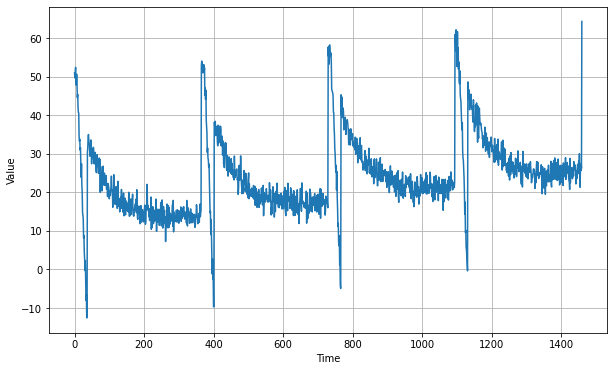

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Now that we have the time series, let's split it so we can start forecasting

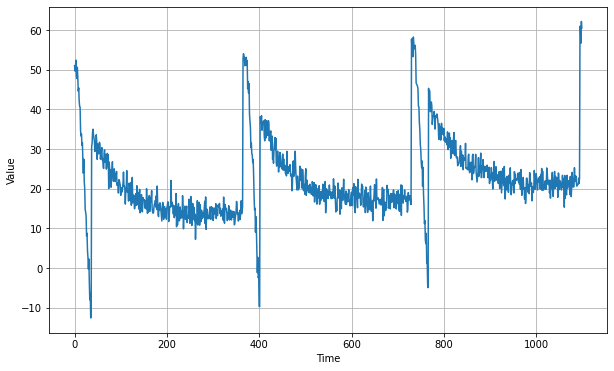

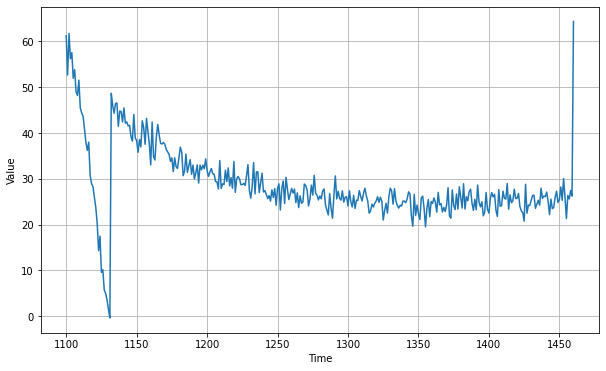

In [5]:
split_time = 1100# YOUR CODE HERE
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [6]:
series

array([50.993427, 49.660896, 51.025326, ..., 27.43651 , 26.209599,
       64.32309 ], dtype=float32)

In [7]:
naive_forecast = series[split_time-1:-1]

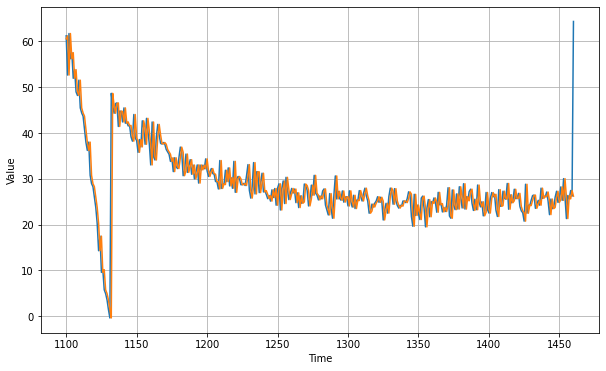

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay

Let's zoom in on the start of the validation period:

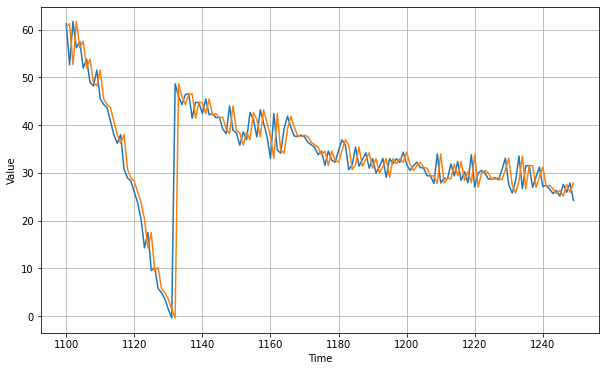

In [9]:
plt.figure(figsize=(10, 6))


plot_series(time[1100:1250],x_valid[:150])
plot_series(time[1100:1250],naive_forecast[:150])

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [10]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

19.578306
2.6011972


That's our baseline, now let's try a moving average:

In [11]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    ### START CODE HERE  
    
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
      
    return np.array(forecast)
    
    ### END CODE HERE

361


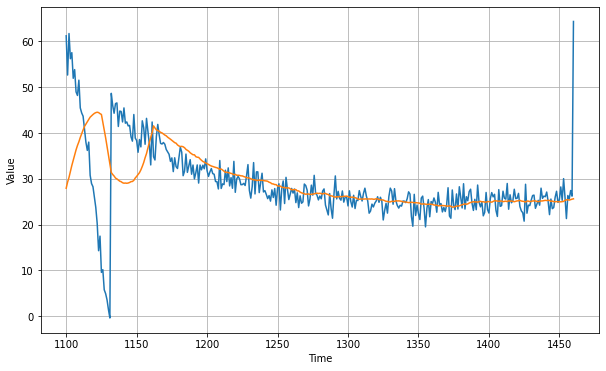

In [20]:
moving_avg = moving_average_forecast(series,30)[split_time-30:] # the value 30 depends on the period we want to make the average!! 
print(len(moving_avg))
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [13]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

65.78622
4.3040023



```
# This is formatted as code
```

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

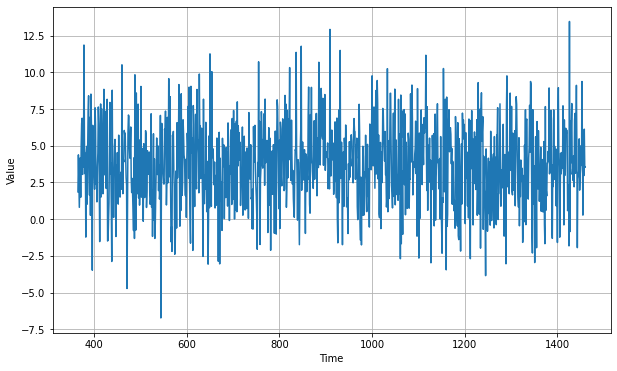

In [14]:
diff_series = (series[365:] - series[:-365])# value 365 is because the period of the time series is 365!!
diff_time = time[365:]# YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

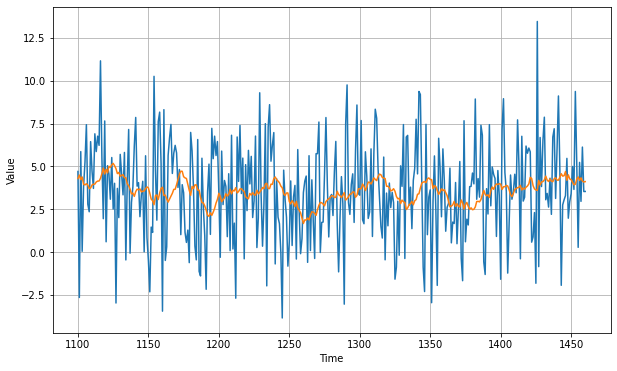

In [15]:
diff_moving_avg = moving_average_forecast(diff_series,20)[split_time-365-20:]# we use 20 as the values for averaging!!! 

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t – 365:

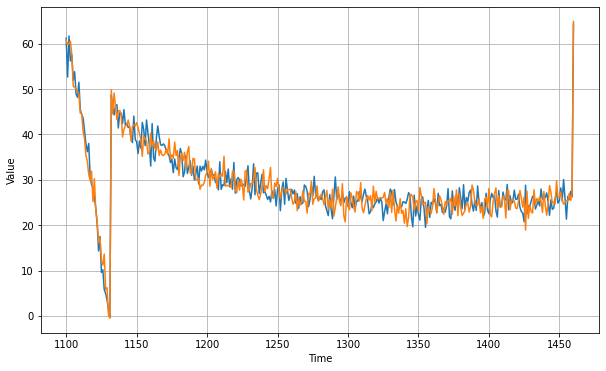

In [16]:
diff_moving_avg_plus_past = series[split_time-365:-365]+ diff_moving_avg  # YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)# YOUR CODE HERE)
plot_series(time_valid, diff_moving_avg_plus_past)# YOUR CODE HERE)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [17]:
print(tf.keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_past).numpy())# YOUR CODE HERE)
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())# YOUR CODE HERE)
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.867627
2.382099


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

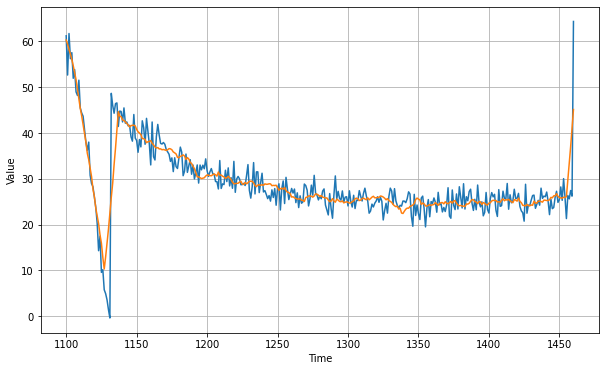

In [21]:
diff_moving_avg_plus_smooth_past = diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg 
# it is 370 & 360 because we take a windows center average approach at +/- 5 days hence 10 days centered on the day of interest

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [19]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())# YOUR CODE HERE)
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())# YOUR CODE HERE)
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

12.850275
2.2400968
